In [49]:
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

(169, 281)


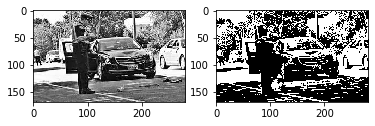

In [51]:
car_image = imread("3.jfif", as_grey=True)
# it should be a 2 dimensional array
print(car_image.shape)

gray_car_image = car_image * 255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_car_image, cmap="gray")
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value
ax2.imshow(binary_car_image, cmap="gray")
plt.show()


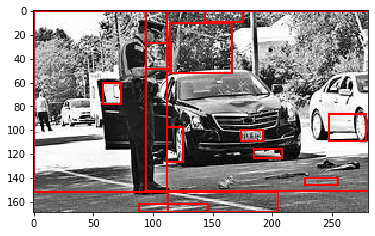

In [57]:
from skimage import measure
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import localization

# this gets all the connected regions and groups them together
label_image = measure.label(binary_car_image)
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray");

# regionprops creates a list of properties of all the labelled regions
for region in regionprops(label_image):
    if region.area < 50:
        #if the region is so small then it's likely not a license plate
        continue

    # the bounding box coordinates
    minRow, minCol, maxRow, maxCol = region.bbox
    rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)
    # let's draw a red rectangle over those regions

plt.show()

C:\Users\preeti sharma\falcor-app-server\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


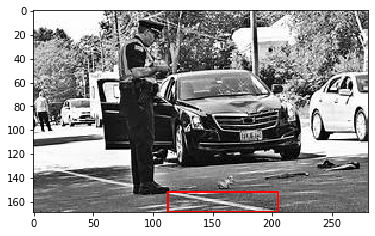

In [88]:
from skimage import measure
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import localization

# this gets all the connected regions and groups them together
label_image = measure.label(binary_car_image)

# getting the maximum width, height and minimum width and height that a license plate can be
plate_dimensions = (0.08*label_image.shape[0], 0.2*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1])
min_height, max_height, min_width, max_width = plate_dimensions
plate_objects_cordinates = []
plate_like_objects = []
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray");

# regionprops creates a list of properties of all the labelled regions
for region in regionprops(label_image):
    if region.area < 50:
        #if the region is so small then it's likely not a license plate
        continue

    # the bounding box coordinates
    min_row, min_col, max_row, max_col = region.bbox
    region_height = max_row - min_row
    region_width = max_col - min_col
    # ensuring that the region identified satisfies the condition of a typical license plate
    if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
        plate_like_objects.append(binary_car_image[min_row:max_row,
                                  min_col:max_col])
        plate_objects_cordinates.append((min_row, min_col,
                                              max_row, max_col))
        rectBorder = patches.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
    # let's draw a red rectangle over those regions

plt.show()

In [64]:
import numpy as np
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cca2

# on the image I'm using, the headlamps were categorized as a license plate
# because their shapes were similar
# for now I'll just use the plate_like_objects[2] since I know that's the
# license plate. We'll fix this later

# The invert was done so as to convert the black pixel to white pixel and vice versa
license_plate = np.invert(cca2.plate_like_objects[2])

labelled_plate = measure.label(license_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")
# the next two lines is based on the assumptions that the width of
# a license plate should be between 5% and 15% of the license plate,
# and height should be between 35% and 60%
# this will eliminate some
character_dimensions = (0.35*license_plate.shape[0], 0.60*license_plate.shape[0], 0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x0)

plt.show()

ModuleNotFoundError: No module named 'cca2'

In [77]:


import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from skimage.io import imread
from skimage.filters import threshold_otsu

letters = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
        ]

def read_training_data(training_directory):
    image_data = []
    target_data = []
    for each_letter in letters:
        for each in range(10):
            image_path = os.path.join(training_directory, each_letter, each_letter + '_' + str(each) + '.jpg')
            # read each image of each character
            img_details = imread(image_path, as_grey=True)
            # converts each character image to binary image
            binary_image = img_details < threshold_otsu(img_details)
            # the 2D array of each image is flattened because the machine learning
            # classifier requires that each sample is a 1D array
            # therefore the 20*20 image becomes 1*400
            # in machine learning terms that's 400 features with each pixel
            # representing a feature
            flat_bin_image = binary_image.reshape(-1)
            image_data.append(flat_bin_image)
            target_data.append(each_letter)

    return (np.array(image_data), np.array(target_data))

def cross_validation(model, num_of_fold, train_data, train_label):
    # this uses the concept of cross validation to measure the accuracy
    # of a model, the num_of_fold determines the type of validation
    # e.g if num_of_fold is 4, then we are performing a 4-fold cross validation
    # it will divide the dataset into 4 and use 1/4 of it for testing
    # and the remaining 3/4 for the training
    accuracy_result = cross_val_score(model, train_data, train_label,
                                      cv=num_of_fold)
    print("Cross Validation Result for ", str(num_of_fold), " -fold")

    print(accuracy_result * 100)


current_dir = os.path.dirname("3.jfif")

training_dataset_dir = os.path.join(current_dir, 'train')

image_data, target_data =("3.jfif")

# the kernel can be 'linear', 'poly' or 'rbf'
# the probability was set to True so as to show
# how sure the model is of it's prediction
svc_model = SVC(kernel='linear', probability=True)

cross_validation(svc_model, 4, image_data, target_data)

# let's train the model with all the input data
svc_model.fit(image_data, target_data)

# we will use the joblib module to persist the model
# into files. This means that the next time we need to
# predict, we don't need to train the model again
save_directory = os.path.join(current_dir, 'models/svc/')
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
joblib.dump(svc_model, save_directory+'/svc.pkl')

ValueError: too many values to unpack (expected 2)

In [86]:
import os
import skimage
from sklearn.externals import joblib

# load the model
current_dir = os.path.dirname("3.jfif")
model_dir = os.path.join(current_dir, "3.jfif")
model = joblib.load(model_dir)

classification_result = []
for each_character in segmentation.characters:
    # converts it to a 1D array
    each_character = each_character.reshape(1, -1);
    result = model.predict(each_character)
    classification_result.append(result)

print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

print(plate_string)

# it's possible the characters are wrongly arranged
# since that's a possibility, the column_list will be
# used to sort the letters in the right order

column_list_copy = segmentation.column_list[:]
segmentation.column_list.sort()
rightplate_string = ''
for each in segmentation.column_list:
    rightplate_string += plate_string[column_list_copy.index(each)]

print(rightplate_string)

KeyError: 255

In [87]:
import numpy as np
import cv2
import os
import sys
import time
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import skimage.io as io